## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [188]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [3]:
# Use GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [4]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [70]:
train_dataset[1]

(4,
 "This week in VoIP news The nation's top telephone regulators further deregulated Internet phone services.")

In [5]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [6]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [7]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [8]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [9]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [10]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [11]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [12]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))
    
    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [14]:
EMBEDDING_SIZE = 20
HIDDEN_SIZE = 64
FC_HIDDEN_SIZE = 64
NUM_CLASSES = 4
LR = 0.005
torch.manual_seed(1)

In [15]:
class RNN(nn.Module):
    def __init__(self, embed_size, rnn_hidden_size, fc_hidden_size, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size)
        self.rnn = nn.LSTM(embed_size, rnn_hidden_size, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        
    def forward(self, x):
        out = self.embedding_layer(x)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [16]:
model = RNN(EMBEDDING_SIZE, HIDDEN_SIZE, FC_HIDDEN_SIZE, NUM_CLASSES).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
model

RNN(
  (embedding_layer): Embedding(95811, 20)
  (rnn): LSTM(20, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [17]:
# def accuracy(dataloader):
#     model.eval()
#     total_acc, total_loss = 0, 0
#     with torch.no_grad():
#         for text_batch, label_batch, lengths in dataloader:
#             pred = model(text_batch, lengths)[:, 0]
#             loss = loss_fn(pred, label_batch)
#             total_acc += (
#                 (pred>=0.5).float() == label_batch
#             ).float().sum().item()
#             total_loss += loss.item()*label_batch.size(0)
#     return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    cost = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.int32)
            y = y.to(device=device, dtype=torch.int32)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            _, preds = scores.max(1)

            num_correct += (preds == y).sum()
            num_total += preds.size(0)

        return cost/len(loader), float(num_correct) / num_total

In [18]:
# def train(dataloader):
#     model.train()
#     total_acc, total_loss = 0, 0
#     for text_batch, label_batch, lengths in dataloader:
#         optimizer.zero_grad()
#         pred = model(text_batch, lengths)[:, 0]
#         loss = loss_fn(pred, label_batch)
#         loss.backward()
#         optimizer.step()
#         total_acc += (
#             (pred >= 0.5).float() == label_batch
#         ).float().sum().item()
#         total_loss += loss.item()*label_batch.size(0)
#     return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def train_model(model, optimizer, epochs=100):
    model = model.to(device)
    train_cost = 0
    val_cost = 0

    for epoch in range(epochs):
        train_correct_num = 0.
        train_total = 0.
        train_cost_acum = 0.

        for x, y in train_loader:
            model.train()
            x = x.to(device=device, dtype=torch.int32)
            y = y.to(device=device, dtype=torch.int32)

            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)
            train_cost_acum += cost.item()

        val_cost, val_acc = accuracy(model, val_loader)
        train_acc = float(train_correct_num) / train_total
        train_cost = train_cost_acum / len(train_loader)

        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f},'
                      f' lr: {optimizer.param_groups[0]["lr"]:.6f}')

In [19]:
epochs = 10

In [20]:
train_model(model, optimizer, epochs)

Epoch:0, train cost: 0.854454, val cost: 0.417756, train acc: 0.6219, val acc: 0.856750, lr: 0.005000
Epoch:1, train cost: 0.318797, val cost: 0.312461, train acc: 0.8949, val acc: 0.890083, lr: 0.005000
Epoch:2, train cost: 0.222174, val cost: 0.308410, train acc: 0.9284, val acc: 0.901500, lr: 0.005000
Epoch:3, train cost: 0.169944, val cost: 0.298283, train acc: 0.9454, val acc: 0.904250, lr: 0.005000
Epoch:4, train cost: 0.131816, val cost: 0.310300, train acc: 0.9585, val acc: 0.905583, lr: 0.005000
Epoch:5, train cost: 0.103221, val cost: 0.329338, train acc: 0.9675, val acc: 0.902583, lr: 0.005000
Epoch:6, train cost: 0.079906, val cost: 0.361620, train acc: 0.9747, val acc: 0.900583, lr: 0.005000
Epoch:7, train cost: 0.063298, val cost: 0.409405, train acc: 0.9803, val acc: 0.900583, lr: 0.005000
Epoch:8, train cost: 0.048866, val cost: 0.420010, train acc: 0.9847, val acc: 0.894167, lr: 0.005000
Epoch:9, train cost: 0.039682, val cost: 0.481440, train acc: 0.9878, val acc: 0.8

In [21]:
# print(f'{accuracy(gru_model, test_loader):.4f}')
accuracy(model, test_loader)[1]*100

90.14473684210526

In [146]:
it = iter(test_loader)
first = next(it)
item = first[0][0]
item = item.view(1, 50)
item.shape


torch.Size([1, 50])

In [184]:
def sample_text(model, loader):
    # Function to sample text to try the model
    model.eval()
    model.to(device=device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(dim=1)
            print(f'Predicted: {labels[preds[0]]}, Actual: {labels[y[0]]}')
            break

In [166]:
ukraine = 'Ukraine has been hit by a terrible russian hacking attack, leaving them without power in the whole country'

x = [vocab(tokeniser(text)) for text in ukraine]
x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]
len(x[0])

# x = [vocab(tokeniser(text)) for text in x]
# x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

50

In [187]:
# sample_text(model, item)
sample_text(model, val_loader)

Predicted: Sports, Actual: Sports


In [181]:
def plot_confusion_matrix(model, loader):
  model.eval()
  model.to(device=device)

  y_true = []
  y_pred = []

  with torch.no_grad():
      for x, y in loader:
          x = x.to(device=device)
          y = y.to(device=device)
          scores = model(x)
          _, predictions = scores.max(dim=1)
          y_true.extend(y.cpu().numpy())
          y_pred.extend(predictions.cpu().numpy())

  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot()

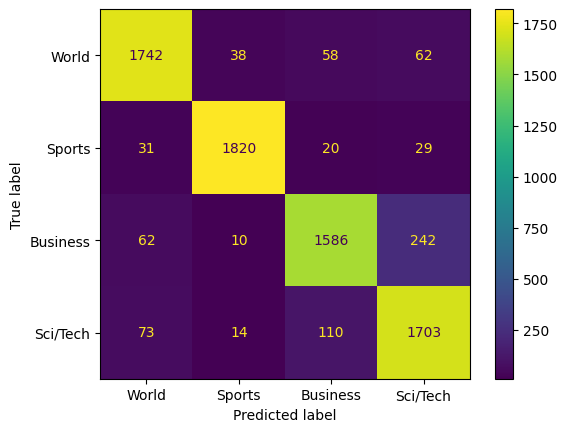

In [183]:
plot_confusion_matrix(model, test_loader)